<a href="https://colab.research.google.com/github/eroj333/learning-cv-ml/blob/master/SNN/Learning%20Similarity%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One shot learning and Siamese NN
 

In [1]:
import keras as k
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam


# Dataset :-


In [2]:
(x_train_master, y_train_master), (x_test_master, y_test_master) = k.datasets.fashion_mnist.load_data()

In [3]:
x_train_master = np.expand_dims(x_train_master, axis=3) / 255
x_test_master = np.expand_dims(x_test_master, axis=3) / 255

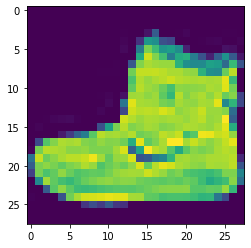

In [4]:
plt.imshow( np.squeeze(x_train_master[0]))

In [4]:
def create_tuples(x, y, n_ways):
  y = y.flatten()
  x_t1 = []
  x_t2 = []
  target = []
  length = len(y)
  
  for i in range(length):
    cur_x, cur_y = x[i], y[i]
    choices = np.random.choice(length, n_ways, replace=False)
    choices_x, choices_y = x[choices], y[choices]
    for j in range(n_ways):
      _x, _y = choices_x[j], choices_y[j]
      x_t1.append(cur_x)
      x_t2.append(_x)
      target.append(1 if cur_y == _y else 0)
    
  return [np.array(x_t1), np.array(x_t2)], np.array(target)

def equalize_class_examples(x, y):
  x1, x2 = x
  y1 = np.where(y == 1) 
  
  n = y1[0].shape[0]
  y0 = np.where(y == 0)[0]
  y0 = y0[:n]
  
  xa = np.vstack((x1[y1], x1[y0]))
  xb = np.vstack((x2[y1], x2[y0]))
  
  yp = np.hstack((y[y1], y[y0]))
  return [xa, xb], yp

def get_training_data(sample_per_class=5, n_ways=5, valid_sample_per_class=2, test_sample_per_class=2):
  train_x, train_y, valid_x, valid_y, test_x, test_y = None, None, None, None, None, None
  
  for i in range(10):
    indices = np.argwhere(y_train_master == i)
    choice = np.random.choice(indices.shape[0], sample_per_class + valid_sample_per_class, replace=False)
    choice = indices[choice]

    sub_train_x = x_train_master[choice[:sample_per_class]]
    sub_train_y = y_train_master[choice[:sample_per_class]]
    
    sub_valid_x = x_train_master[choice[sample_per_class:]]
    sub_valid_y = y_train_master[choice[sample_per_class:]]
    
    
    
    t_indices = np.argwhere(y_test_master == i)
    t_choice = np.random.choice(t_indices.shape[0], test_sample_per_class, replace=False)
    t_choice = t_indices[t_choice]
    sub_test_x = x_test_master[t_choice]
    sub_test_y = y_test_master[t_choice]
    
    sub_train_x, sub_train_y, sub_valid_x, sub_valid_y, sub_test_x, sub_test_y = np.squeeze(sub_train_x, axis=1), (sub_train_y), np.squeeze(sub_valid_x, axis=1), (sub_valid_y), np.squeeze(sub_test_x, axis=1), (sub_test_y)
    if(train_x is None):
      train_x, train_y, valid_x, valid_y, test_x, test_y = sub_train_x, sub_train_y, sub_valid_x, sub_valid_y, sub_test_x, sub_test_y
    else:
      train_x = np.vstack((train_x, sub_train_x))
      train_y = np.vstack((train_y, sub_train_y))
  #     train_x.append(sub_train_x)
  #     train_y.append(sub_train_y)

      valid_x = np.vstack((valid_x, sub_valid_x))
      valid_y = np.vstack((valid_y, sub_valid_y))
  #     valid_x.append(sub_valid_x)
  #     valid_y.append(sub_valid_y)

      test_x = np.vstack((test_x, sub_test_x))
      test_y = np.vstack((test_y, sub_test_y))

  #     test_x.append(sub_test_x)
  #     test_y.append(sub_test_y)
  print(train_x.shape, train_y.shape)
  train_x, train_y = create_tuples(train_x, train_y, n_ways)
  train_x, train_y = equalize_class_examples(train_x, train_y)
  valid_x, valid_y = create_tuples(valid_x, valid_y, n_ways)
  valid_x, valid_y = equalize_class_examples(valid_x, valid_y)
  test_x, test_y = create_tuples(test_x, test_y, n_ways)
  test_x, test_y = equalize_class_examples(test_x, test_y)
  
  return train_x, train_y, valid_x, valid_y, test_x, test_y
  
    

In [5]:
def visualize_data(data, data_class, n):
  n = min(len(data[0]), n)
  print("Same class: ", np.where(data_class ==1)[0].shape[0], "Different class: ", np.where(data_class==0)[0].shape[0])
  fig, ax = plt.subplots(n, 2,figsize=(10,40))
  inp1, inp2 = data
  for i in range(n):
    ax[i, 0].imshow(np.squeeze(inp1[i]), cmap="gray")
    ax[i, 1].imshow(np.squeeze(inp2[i]), cmap="gray")
    # x_class = str(data_class[i].tolist())
    # ax[i, 1].set_title("class " + x_class)

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()

In [6]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_training_data(sample_per_class=50, n_ways=10, valid_sample_per_class=20, test_sample_per_class=50)

(500, 28, 28, 1) (500, 1)


Same class:  443 Different class:  443


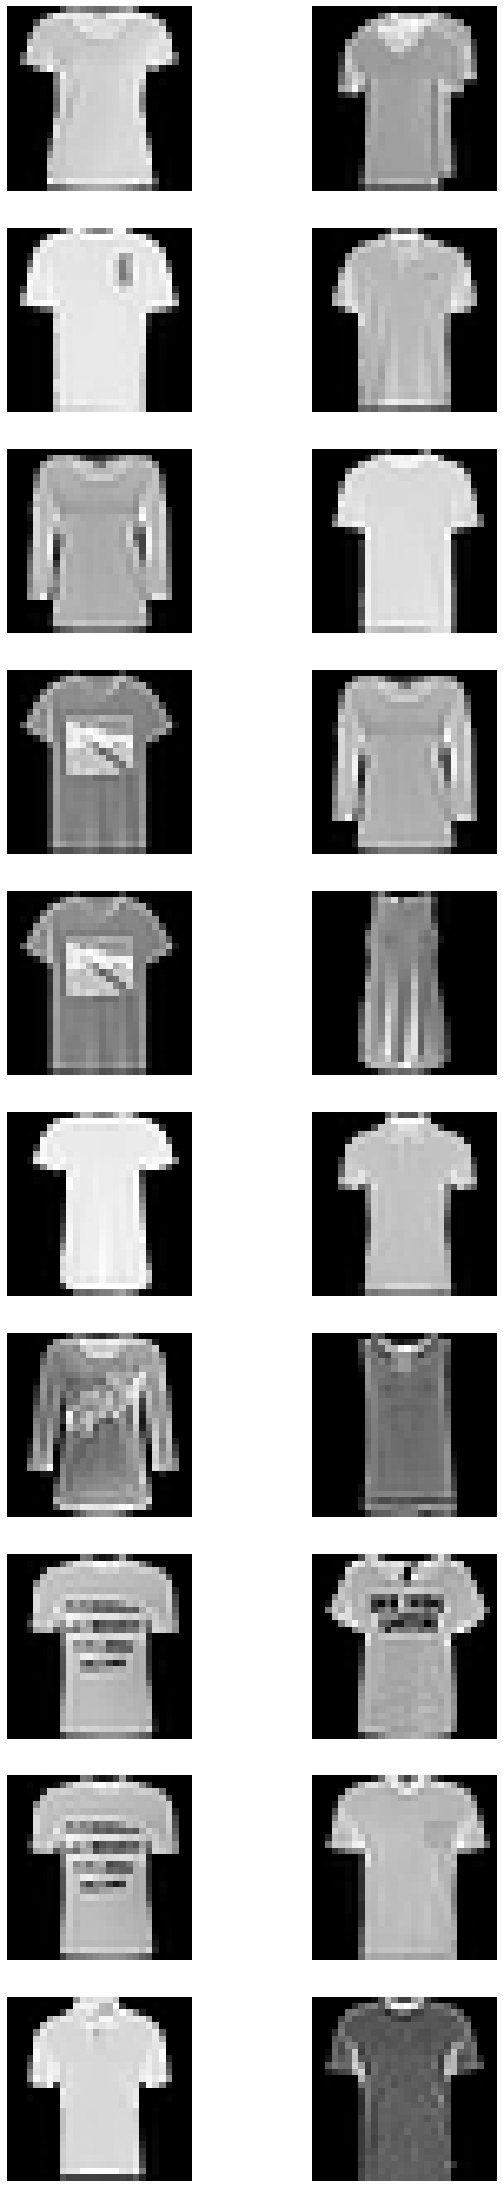

In [7]:
visualize_data(train_x, train_y, 10)


# Learning similarity function



In [8]:
initialize_weights = k.initializers.RandomNormal(mean=0.0, stddev=0.51, seed=50001)
initialize_bias = k.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=1221)


In [9]:
def get_siamese_conv_unit(input_shape):
  # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(100, (1,1), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid', 
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    model.add(Dropout(rate=.05))
    
    
    return model


def get_classifier_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = get_siamese_conv_unit(input_shape)
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:k.backend.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


In [10]:
ip_shape = (28,28,1)
model = get_classifier_model(ip_shape)

optimizer = Adam(lr = 0.000001)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])



In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         2586852     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           sequential[0][0]      

In [12]:
hist = model.fit(train_x, train_y, epochs=20, validation_data=(valid_x, valid_y))

Epoch 1/20
28/28 [==============================] - 2s 82ms/step - loss: 667.2336 - accuracy: 0.5056 - val_loss: 667.1245 - val_accuracy: 0.5172
Epoch 2/20
28/28 [==============================] - 2s 81ms/step - loss: 667.1726 - accuracy: 0.4910 - val_loss: 667.0712 - val_accuracy: 0.5147
Epoch 3/20
28/28 [==============================] - 2s 71ms/step - loss: 667.1049 - accuracy: 0.5011 - val_loss: 667.0176 - val_accuracy: 0.5123
Epoch 4/20
28/28 [==============================] - 2s 75ms/step - loss: 667.0671 - accuracy: 0.4876 - val_loss: 666.9642 - val_accuracy: 0.5147
Epoch 5/20
28/28 [==============================] - 2s 88ms/step - loss: 666.9874 - accuracy: 0.5147 - val_loss: 666.9107 - val_accuracy: 0.5123
Epoch 6/20
28/28 [==============================] - 2s 78ms/step - loss: 666.9355 - accuracy: 0.5113 - val_loss: 666.8573 - val_accuracy: 0.5147
Epoch 7/20
28/28 [==============================] - 2s 73ms/step - loss: 666.8919 - accuracy: 0.5090 - val_loss: 666.8038 - val_ac

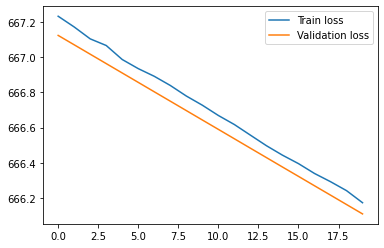

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')

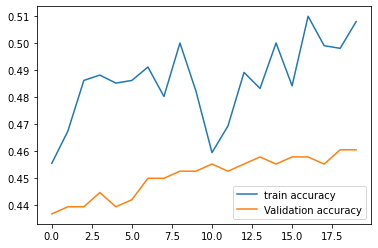

In [18]:
plt.plot(hist.epoch, hist.history["accuracy"], label="train accuracy")
plt.plot(hist.epoch, hist.history["val_accuracy"], label="Validation accuracy")
plt.legend(loc='lower right')